In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import loss_landscapes
import loss_landscapes.metrics

import utils
import numpy as np

In [2]:
# training hyperparameters
BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
EPOCHS = 5
LR = 10 ** -2
GAMMA = 0.7 #learning rate step gamma
LOG_INTERVAL = 1000

# contour plot resolution
STEPS = 40

use_cuda = True
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(model, criterion, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [4]:
train_kwargs = {'batch_size': BATCH_SIZE}
test_kwargs = {'batch_size': TEST_BATCH_SIZE}

In [5]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
dataset1 = datasets.MNIST('./data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('./data', train=False,
                    transform=transform)

# Filtered train_loader and test_loader
# For labels 0-4
labels = [0,1,2,3,4]
indices = [idx for idx, target in enumerate(dataset1.targets) if target in labels]
train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset1, indices),**train_kwargs)

# For labels 0-4
labels = [5,6,7,8,9]
#labels = [0,1,2,3,4]
indices = [idx for idx, target in enumerate(dataset2.targets) if target in labels]
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset2, indices),**train_kwargs)

# Default train_loader and test_loader
#train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
#test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [6]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=1, gamma=GAMMA)
for epoch in range(1, EPOCHS + 1):
    train(model, criterion, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/30596 (0%)]	Loss: 2.324065

Test set: Average loss: 8.3940, Accuracy: 0/4861 (0%)

Train Epoch: 2 [0/30596 (0%)]	Loss: 0.186675

Test set: Average loss: 8.7727, Accuracy: 0/4861 (0%)

Train Epoch: 3 [0/30596 (0%)]	Loss: 0.093487

Test set: Average loss: 8.9531, Accuracy: 0/4861 (0%)

Train Epoch: 4 [0/30596 (0%)]	Loss: 0.079973

Test set: Average loss: 9.1572, Accuracy: 0/4861 (0%)

Train Epoch: 5 [0/30596 (0%)]	Loss: 0.090948

Test set: Average loss: 9.1152, Accuracy: 0/4861 (0%)



In [7]:
# Get all the model parameters
params = [p for p in model.parameters()]

# Calculate the standard deviation of all parameters
wt_std = torch.std(torch.cat([p.view(-1) for p in params]))

DISTANCE=10*wt_std.cpu().detach().numpy()

print(DISTANCE)

0.08318091742694378


In [8]:
perturbation_range = np.round(np.linspace(-0.5*DISTANCE, 0.5*DISTANCE, 8), 3)

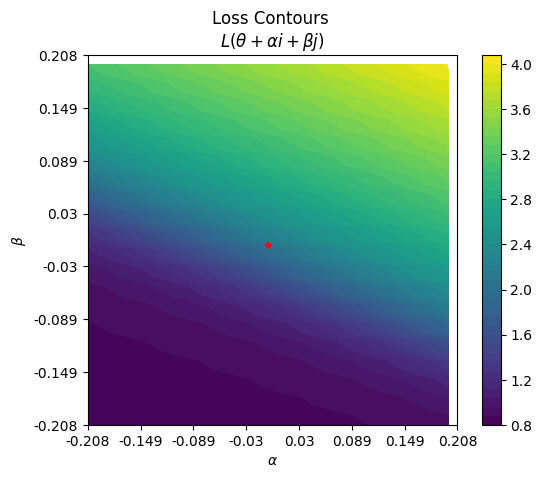

In [9]:
x, y = iter(test_loader).__next__()

metric = loss_landscapes.metrics.Loss(criterion, x, y)

loss_data_fin = loss_landscapes.random_plane(model.cpu(), metric, distance=DISTANCE*5, steps=STEPS, normalization='filter', deepcopy_model=True)

utils.plot_loss_contours(loss_data=loss_data_fin, steps=STEPS, distance=DISTANCE*5, save_fig=True)